In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8])

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13974 entries, 2019-04-16 19:34:42 to 2019-04-17 12:55:14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   request_method  13974 non-null  object
 2   status          13974 non-null  int64 
 3   size            13974 non-null  int64 
 4   destination     25 non-null     object
 5   request_agent   13974 non-null  object
dtypes: int64(2), object(4)
memory usage: 764.2+ KB


In [6]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [7]:
df.describe()

,status,size,size_mb
count,13974.000000,13974.000000,13974.000000
mean,200.342350,449900.797338,0.429059
std,10.112012,160742.535606,0.153296
min,200.000000,0.000000,0.000000
25%,200.000000,500637.000000,0.477445
50%,200.000000,510138.000000,0.486506
75%,200.000000,511291.000000,0.487605
max,499.000000,513736.000000,0.489937


In [8]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [9]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [10]:
df.drop(columns= 'size', inplace = True)

In [11]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [12]:
ip_df.head()

,ip,ip_count
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21


In [13]:
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna = False)/df.ip.count()).reset_index().rename(index = str , columns = {'index':'ip','ip':'ip_proba'})

In [14]:
ip_df2

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503
5,68.201.219.223,0.001503
6,52.87.230.102,0.000143
7,70.121.214.34,0.000143
8,35.175.171.137,0.000143
9,3.88.129.158,0.000072


In [15]:
ip_df = ip_df.merge(ip_df2)

In [16]:
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 18
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ip        19 non-null     object 
 1   ip_count  19 non-null     int64  
 2   ip_proba  19 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 608.0+ bytes


In [17]:
merged = df.merge(ip_df, on = 'ip', how = 'left')

In [18]:
merged[merged['ip_proba'] <= .01].groupby('ip').count()

,request_method,status,destination,request_agent,size_mb,ip_count,ip_proba
ip,,,,,,,
24.26.242.9,21,21,0,21,21,21,21
3.88.129.158,1,1,0,1,1,1,1
3.92.201.136,1,1,0,1,1,1,1
34.207.64.242,1,1,0,1,1,1,1
34.229.70.250,1,1,0,1,1,1,1
35.174.209.2,1,1,0,1,1,1,1
35.175.171.137,2,2,0,2,2,2,2
45.23.250.16,1,1,0,1,1,1,1
52.87.230.102,2,2,0,2,2,2,2


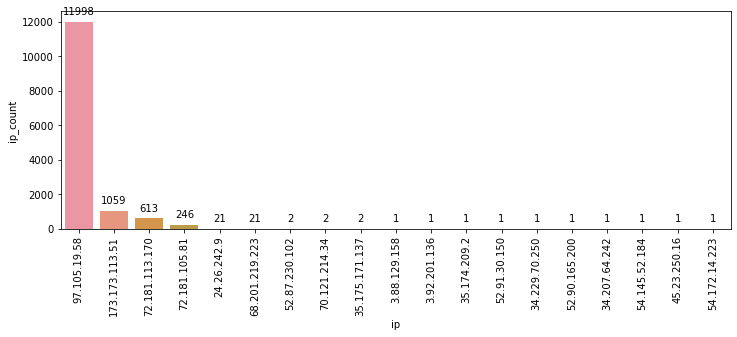

In [19]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [20]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [21]:
train = train[['ip','request_method','status','destination','request_agent','size_mb']]

In [22]:
ip_train = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [23]:
df = df.reset_index().merge(ip_train, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.ip_proba.value_counts()

0.858595    11998
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
Name: ip_proba, dtype: int64

In [24]:
ip_probs = train.groupby('ip').size().div(len(df))

In [25]:
status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [26]:
status_given_ip.head()

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [27]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))

In [28]:
ip_status = status_given_ip.merge(ip_status_count)

In [29]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13974 entries, 2019-04-16 19:34:42 to 2019-04-17 12:55:14
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ip                     13974 non-null  object 
 1   request_method         13974 non-null  object 
 2   status                 13974 non-null  int64  
 3   destination            13974 non-null  object 
 4   request_agent          13974 non-null  object 
 5   size_mb                13974 non-null  float64
 6   ip_proba               13974 non-null  float64
 7   proba_status_given_ip  13974 non-null  float64
 8   ip_status_count        13974 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 1.1+ MB


In [31]:
request_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_count'})

In [32]:
request_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_proba'})
request_df = request_df.merge(request_df2)

In [33]:
request_df

,request_method,request_count,request_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887577
1,GET /api/v1/items HTTP/1.1,1065,0.076213
2,GET /api/v1/stores HTTP/1.1,229,0.016388
3,GET / HTTP/1.1,107,0.007657
4,GET /documentation HTTP/1.1,100,0.007156
5,GET /favicon.ico HTTP/1.1,26,0.001861
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286


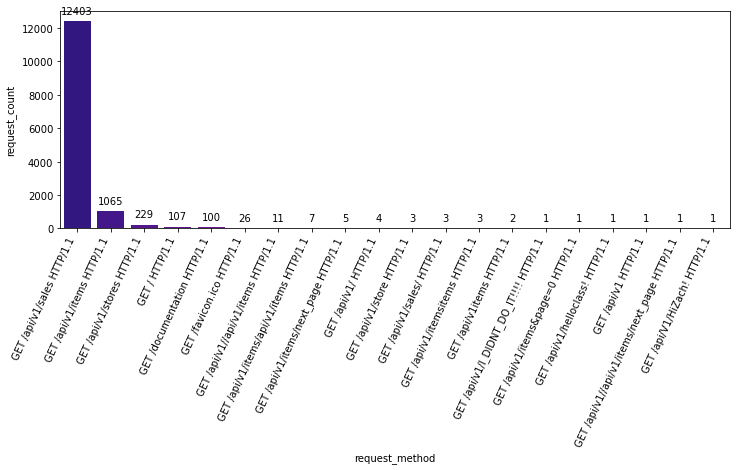

In [34]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_df, x = 'request_method', y = 'request_count', ci = None, palette = 'plasma' )
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    
    plt.xticks(ha = 'right',rotation=65)

In [35]:
request_df[request_df['request_proba'] <= .01]

,request_method,request_count,request_proba
3,GET / HTTP/1.1,107,0.007657
4,GET /documentation HTTP/1.1,100,0.007156
5,GET /favicon.ico HTTP/1.1,26,0.001861
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/store HTTP/1.1,3,0.000215
11,GET /api/v1/sales/ HTTP/1.1,3,0.000215
12,GET /api/v1/itemsitems HTTP/1.1,3,0.000215


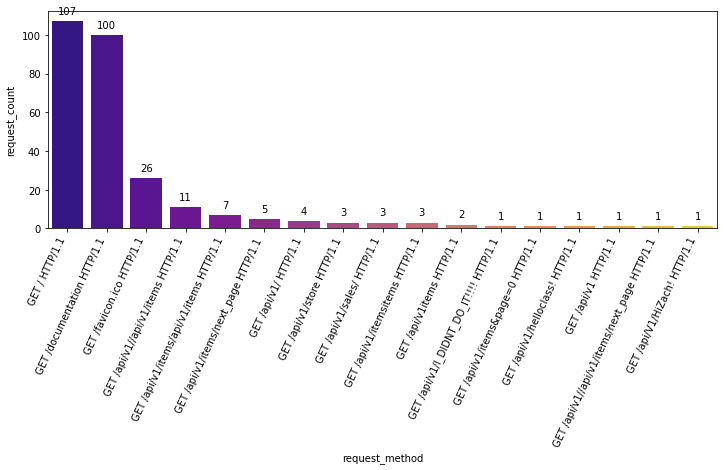

In [36]:
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_df[request_df['request_proba'] <= .01], x = 'request_method', y = 'request_count', ci = None, palette = 'plasma' )
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    
    plt.xticks(ha = 'right',rotation=65)

In [37]:
request_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'method_proba'})
df = df.reset_index().merge(request_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')

In [38]:
request_probs = train.groupby('request_method').size().div(len(df))

status_given_request = pd.DataFrame(train.groupby(['request_method', 'status']).\
                               size().div(len(train)).\
                               div(request_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_request'})
                              )

In [39]:
request_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])['ip'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'ip': 'request_method_status_count'}))


request_status = status_given_request.merge(request_status_count)

In [40]:
request_status

,request_method,status,proba_status_given_request,request_method_status_count
0,GET / HTTP/1.1,200,1.000000,107
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000,1
2,GET /api/v1 HTTP/1.1,200,1.000000,1
3,GET /api/v1/ HTTP/1.1,200,1.000000,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000,11
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000,1
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000,1
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000,1
8,GET /api/v1/items HTTP/1.1,200,0.996244,1061
9,GET /api/v1/items HTTP/1.1,499,0.003756,4


In [41]:
df = df.reset_index().merge(request_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [42]:
df

,ip,request_method,status,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count,method_proba,proba_status_given_request,request_method_status_count
timestamp,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,0.858595,0.998833,11984,0.887577,0.999032,12391
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.858595,0.998833,11984,0.076213,0.996244,1061
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,0.858595,0.998833,11984,0.887577,0.999032,12391
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,0.858595,0.998833,11984,0.887577,0.999032,12391
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,0.858595,0.998833,11984,0.887577,0.999032,12391
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-17 12:55:12,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.487846,0.858595,0.998833,11984,0.887577,0.999032,12391
2019-04-17 12:55:12,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.487519,0.858595,0.998833,11984,0.887577,0.999032,12391
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488072,0.858595,0.998833,11984,0.887577,0.999032,12391


In [43]:
plt.scatter(df.proba_status_given_request, df.request_proba)

AttributeError: 'DataFrame' object has no attribute 'request_proba'